Epoch 1/5
2592/2640 [============================>.] - ETA: 0s - loss: 0.0401

C:\Users\rakes\Miniconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2688/2640 [==============================] - 49s - loss: 0.0402 - val_loss: 0.0283
Epoch 2/5
2688/2640 [==============================] - 47s - loss: 0.0333 - val_loss: 0.0368
Epoch 3/5
2640/2640 [==============================] - 45s - loss: 0.0279 - val_loss: 0.0241
Epoch 4/5
2688/2640 [==============================] - 47s - loss: 0.0287 - val_loss: 0.0275
Epoch 5/5
2688/2640 [==============================] - 49s - loss: 0.0260 - val_loss: 0.0195
dict_keys(['val_loss', 'loss'])


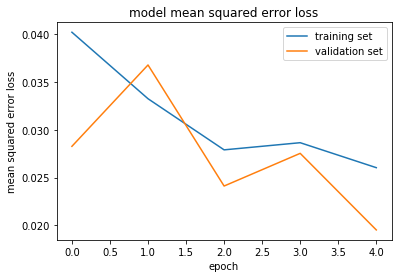

In [41]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import cv2
import os
import csv

#Read all lines from csv file
lines=[]
with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#split data to train and validate
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

#parameters to tune
batchsize = 32
correction = 0.2

#using Generators to work with large amounts of data
def generator(samples, batch_size):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        np.random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images=[]
            measurements=[]
            for batch_sample in batch_samples:
                 #using images from left, center and right cameras
                for i in range(3):
                    source_path = batch_sample[i]
                    filename = source_path.split('\\')[-1]
                    current_path = '../data/IMG/' + filename
                    #read image using the path
                    image = cv2.imread(current_path)
                    #convert the image to RGB colorspace as the image loaded by cv2 is a BGR colorspace 
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    #read steering measurement
                    measurement = float(batch_sample[3])
                    #creating adjusted steering measurements for the side camera images
                    #i=1: left image; i==2: right image
                    if(i == 1):
                        measurement += correction
                    elif(i==2):
                        measurement -= correction
                    measurements.append(measurement)
                    
            #data augmentation: flipping images and taking opposite steering measurement
            augmented_images, augmented_measurements = [], []
            for image, measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(-1.0 * measurement)

            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batchsize)
validation_generator = generator(validation_samples, batchsize)

#Using NVIDIA architecture: Normalization layer, 5 Convolutional, 4 fc layers
#Creating sequential model using keras
model = Sequential()

#adding lambda layer to normalize input images
# Preprocess incoming data, centered around zero with small standard deviation 
#Pass input_shape to the first layer
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3)))

#Using Keras Cropping2D to crop input images simultaneously when making predictions
#crop top pixels of image 70 rows, bottom 25 pixels, 
#0 from left and 0 from right
model.add(Cropping2D(cropping=((70,25),(0,0))))

model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#using model.fit_generator to output history object that contains training 
#and validation loss for each epoch
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5, verbose=1)

#save the model
model.save('model.h5')

### print the keys contained in the history object
#print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
